In [68]:
import numpy as np

In [69]:
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.datasets import boston_housing

In [70]:
# (X_train, y_train), (X_test, y_test) = boston_housing.load_data()

# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
# X_train.shape
# X_test.shape

In [71]:
data = pd.read_csv('./Life Expectancy Data.csv')
data
data = data.drop(['Country'], axis=1)
data = data.drop(['Status'], axis=1)
data = data.drop(['Year'], axis=1)
data = data.dropna()

X = data.drop(data.columns[0], axis=1).to_numpy()
X
y = data.iloc[:, 0].to_numpy()
y

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=456)

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape)
print(X_test.shape)

(1154, 18)
(495, 18)


In [72]:
class DenseLayer:
    def __init__(self, activation_function, isLastLayer, weightsMatrix, bias):
        self.isLastLayer = isLastLayer
        self.activation_function = activation_function
        self.weights = weightsMatrix
        self.bias = bias
    
    def get_output(self, layer_input):
        self.layer_input = layer_input
        
        if self.isLastLayer:
            return np.dot(self.weights, self.layer_input) + self.bias
        else:
            a = np.dot(self.weights, self.layer_input) + self.bias
            return self.relu(a)
    
    def relu(self, xs):
        return np.array(list(map(lambda x: max(x,0.0), xs)))

In [73]:
class NeuralNetwork():
    def __init__(self, code, num_of_layers, num_of_units_per_layer, X, y):
        self.layers = []
        self.loss = None
        self.X = X
        self.y = y
        self.code = code
        self.num_of_layers = num_of_layers
        self.num_of_units_per_layer = num_of_units_per_layer
        self.fitness = self.calcFitness()
        
    def decodeWeightsAddLayers(self):
        for i in range(self.num_of_layers - 1):
            limit = self.num_of_units_per_layer[i] * self.num_of_units_per_layer[i+1] + self.num_of_units_per_layer[i+1]
            weights1 = np.array(self.code[:self.num_of_units_per_layer[i] * self.num_of_units_per_layer[i+1]])
            bias = self.code[self.num_of_units_per_layer[i] * self.num_of_units_per_layer[i+1]:limit]
            
            weightsMatrix = weights1.reshape(self.num_of_units_per_layer[i+1], self.num_of_units_per_layer[i])
            
            isLastLayer = i == self.num_of_layers-2
            
            self.layers.append(DenseLayer('relu', isLastLayer, weightsMatrix, bias))
            
    def __lt__(self, other):
        return self.fitness < other.fitness
            
    def calcFitness(self):
        self.decodeWeightsAddLayers()
        y_pred = self.all_results()
        return -self.mae(self.y, y_pred)
        
    def add_layer(self, layer):
        self.layers.append(layer)
        
    def mse(self, y_trues, y_preds):
        return np.sum((y_trues-y_preds)**2)/len(y_trues)
        
    def mae(self, y_trues, y_preds):
        return np.sum(abs(y_trues-y_preds))/len(y_trues)
    
    def predict(self, x):
        layer_output = x
        for layer in self.layers:
            layer_output = layer.get_output(layer_output)
        
        return layer_output
    
    def all_results(self):
        results = []
        for i in range(self.X.shape[0]):
            results.append(self.predict(self.X[i])[0])
        return results

In [139]:
num_of_layers = 4 #including input and output
num_of_units_per_layer = [18, 20, 20, 1]

numberOfWeights = 0
for i in range(len(num_of_units_per_layer)-1):
    numberOfWeights += num_of_units_per_layer[i] * num_of_units_per_layer[i+1]
    
numberOfWeights += sum(num_of_units_per_layer) - num_of_units_per_layer[0] # dodao bias za svaki unit

In [140]:
def selection(population):
    TOURNAMENT_SIZE = 16
    bestFitness = float('-inf')
    index = -1
    for i in range(TOURNAMENT_SIZE):
        
        randomIndividual = random.randrange(len(population))
        if population[randomIndividual].fitness > bestFitness:
            bestFitness = population[randomIndividual].fitness
            index = randomIndividual
    return index

In [141]:
def crossover(parent1, parent2, child1, child2):
    breakpoint = random.randrange(len(parent1.code))
    
    child1.code[:breakpoint] = parent1.code[:breakpoint]
    child2.code[:breakpoint] = parent2.code[:breakpoint]
    
    child1.code[breakpoint:] = parent2.code[breakpoint:]
    child2.code[breakpoint:] = parent1.code[breakpoint:]
    
def crossover2(parent1, parent2, child1, child2):
    for i in range(len(parent1.code)):
        r = random.uniform(0.0, 1.0)
        if r < 0.5:
            child1.code[i] = parent1.code[i]
            child2.code[i] = parent2.code[i]
        else:
            child1.code[i] = parent2.code[i]
            child2.code[i] = parent1.code[i]
            
def two_point_crossover(parent1, parent2, child1, child2):
    breakpoint1 = random.randrange(1, len(parent1.code))
    breakpoint2 = random.randrange(1, len(parent1.code) - 1)
    if breakpoint2 >= breakpoint1:
        breakpoint2 += 1
    else:
        breakpoint1, breakpoint2 = breakpoint2, breakpoint1
        
    child1.code[:breakpoint1] = parent1.code[:breakpoint1]
    child1.code[breakpoint1:breakpoint2] = parent2.code[breakpoint1:breakpoint2]
    child1.code[breakpoint2:] = parent1.code[breakpoint2:]
    
    child2.code[:breakpoint1] = parent2.code[:breakpoint1]
    child2.code[breakpoint1:breakpoint2] = parent1.code[breakpoint1:breakpoint2]
    child2.code[breakpoint2:] = parent2.code[breakpoint2:]

In [142]:
import random
def mutation(individual, best):
    MUTATION_PROB = 0.007 * (individual.fitness/best.fitness)**2
    for i in range(len(individual.code)):
        if random.random() < MUTATION_PROB:
            individual.code[i] = random.uniform(-1.2, 1.2)

In [ ]:
POPULATION_SIZE = 100
NUM_GENERATIONS = 300
ELITISM_SIZE = 16

population = [NeuralNetwork(np.random.uniform(low=-1.2, high=1.2, size=numberOfWeights), num_of_layers, num_of_units_per_layer, X_train, y_train) for _ in range(POPULATION_SIZE)]
newPopulation = [NeuralNetwork(np.random.uniform(low=-1.2, high=1.2, size=numberOfWeights), num_of_layers, num_of_units_per_layer, X_train, y_train) for _ in range(POPULATION_SIZE)]
bestMAEs = []
for i in range(NUM_GENERATIONS):
    population.sort(reverse=True)
    newPopulation[:ELITISM_SIZE] = population[:ELITISM_SIZE]
    for j in range(ELITISM_SIZE, POPULATION_SIZE, 2):
        parent1Index = selection(population[ELITISM_SIZE:])
        parent2Index = selection(population[ELITISM_SIZE:])
        
        crossover(population[parent1Index], population[parent2Index], newPopulation[j], newPopulation[j+1])

        mutation(newPopulation[j], max(population))
        mutation(newPopulation[j+1], max(population))

        newPopulation[j] = NeuralNetwork(newPopulation[j].code, num_of_layers, num_of_units_per_layer, X_train, y_train)
        newPopulation[j+1] = NeuralNetwork(newPopulation[j+1].code, num_of_layers, num_of_units_per_layer, X_train, y_train)
        
    population = newPopulation
    print(max(population).fitness)
    bestMAEs.append(-max(population).fitness)
    
bestIndividual = max(population)
print(f'fitness: {bestIndividual.fitness}')

-42.94961507057184
-40.19309427251112
-35.68157363154927
-35.68157363154927
-33.50726124136631
-31.906666411203705
-23.984968978607856
-23.984968978607856
-20.130606633704488
-18.554428403567155
-18.249398720608742
-17.31682277033197
-17.31682277033197
-16.25760968943898
-15.990630268828514
-14.989509775524098
-14.573465005714475
-14.140451857104201
-14.073811812222337
-13.645372466313034
-13.313241598670517
-13.313241598670517
-12.99971751848066
-12.724608557175902
-12.135824949775497


In [ ]:
# (X_train, y_train), (X_test, y_test) = boston_housing.load_data()
# print(bestIndividual.fitness)
# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
nn1 = NeuralNetwork(bestIndividual.code, num_of_layers, num_of_units_per_layer, X_test, y_test)
nn1.fitness

In [ ]:
from matplotlib import pyplot as plt
plt.plot(range(100), bestMAEs)

In [59]:
for i in range(102):
    print(y_test[i], nn1.all_results()[i])

7.2 13.086333134299618
18.8 15.148307763068106
19.0 21.107061097522546
27.0 32.53899537072529
22.2 24.9678085404926
24.5 16.91911790745808
31.2 25.85943517862848
22.9 22.41618343233399
20.5 20.44189340379536
23.2 21.094602259923096
18.6 17.602257304981155
14.5 16.973778173531763
17.8 16.96045612896985
50.0 40.780620368255484
20.8 15.266582878359296
24.3 18.4331969079355
24.2 24.759661477069223
19.8 20.552992372618274
19.1 17.2101321846823
22.7 20.762887149444627
12.0 12.545877609470539
10.2 18.93825509640731
20.0 18.91085214568212
18.5 16.075741109597168
20.9 18.87927942954752
23.0 22.97281504849157
27.5 32.780039135976054
30.1 25.69284468766764
9.5 14.018541980029203
22.0 20.42620440488628
21.2 17.361851839379504
14.1 18.271874229004084
33.1 32.293857465309145
23.4 23.929727517156234
20.1 17.95940759605658
7.4 9.616437417951975
15.4 13.75559941414657
23.8 16.52896428604726
20.1 18.646829921114495
24.5 25.113203630860944
33.0 31.152322313154237
28.4 28.505375382045383
14.1 13.533299681

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model = Sequential()
model.add(Dense(input_dim=X_train.shape[1], units=20, activation='relu'))
model.add(Dense(input_dim=X_train.shape[1], units=20, activation='relu'))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mae', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

Epoch 1/100
29/29 [==============================] - 0s 4ms/step - loss: 68.5345 - mae: 68.5345 - val_loss: 68.7544 - val_mae: 68.7544
Epoch 2/100
29/29 [==============================] - 0s 1ms/step - loss: 67.4568 - mae: 67.4568 - val_loss: 67.5122 - val_mae: 67.5122
Epoch 3/100
29/29 [==============================] - 0s 1ms/step - loss: 65.8316 - mae: 65.8316 - val_loss: 65.5249 - val_mae: 65.5249
Epoch 4/100
29/29 [==============================] - 0s 1ms/step - loss: 63.1152 - mae: 63.1152 - val_loss: 62.1246 - val_mae: 62.1246
Epoch 5/100
29/29 [==============================] - 0s 1ms/step - loss: 58.4212 - mae: 58.4212 - val_loss: 56.4140 - val_mae: 56.4140
Epoch 6/100
29/29 [==============================] - 0s 1ms/step - loss: 51.2290 - mae: 51.2290 - val_loss: 48.0562 - val_mae: 48.0562
Epoch 7/100
29/29 [==============================] - 0s 1ms/step - loss: 42.2026 - mae: 42.2026 - val_loss: 38.6055 - val_mae: 38.6055
Epoch 8/100
29/29 [==============================] - 0s

In [138]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 0s 596us/step - loss: 2.6455 - mae: 2.6455


[2.6455273628234863, 2.6455273628234863]

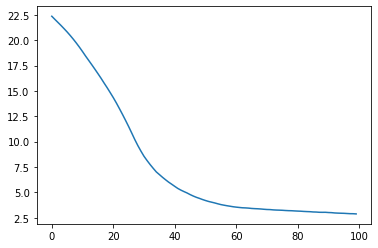

In [62]:
plt.plot(history.epoch, history.history['mae'])